# 1D Forward Simulation for a Single Sounding

In [2]:
# simpeg functionality
import simpeg.electromagnetics.time_domain as tdem
from simpeg import maps
from simpeg.utils import plot_1d_layer_model

# discretize functionality
from discretize import CylindricalMesh, TensorMesh

# Common Python functionality
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

### Defining Survey

The survey composes of the following fours components: 
- **receivers:** There are a multitude of TDEM receiver classes within SimPEG, each of which is used to simulate data corresponding to a different field measurement; e.g. [PointMagneticField](xref:simpeg#simpeg.electromagnetics.time_domain.receivers.PointMagneticField), [PointMagneticFluxTimeDerivative](xref:simpeg#simpeg.electromagnetics.time_domain.receivers.PointMagneticFluxTimeDerivative) and [PointElectricField](xref:simpeg#simpeg.electromagnetics.time_domain.receivers.PointElectricField). The properties for each TDEM receiver object generally include: the orientation of the field being measured (x, y, z, other), the time channels, the data type, and one or more associated observation locations.
- **sources:** There are a multitude of TDEM source classes within SimPEG, each of which corresponds to a different geometry; e.g. [MagDipole](xref:simpeg#simpeg.electromagnetics.time_domain.sources.MagDipole) and [LineCurrent](xref:simpeg#simpeg.electromagnetics.time_domain.sources.LineCurrent). Source classes generally require the user to define the current waveform, location and geometry.
- **waveforms:** The waveform defining the time-dependent current in the source is defined by an object in SimPEG. Some waveform classes include [StepOffWaveform](xref:simpeg#simpeg.electromagnetics.time_domain.sources.StepOffWaveform), [VTEMWaveform](xref:simpeg#simpeg.electromagnetics.time_domain.sources.VTEMWaveform) and [RawWaveform](xref:simpeg#simpeg.electromagnetics.time_domain.sources.RawWaveform)
- **survey:** The object which stores and organizes all of the sources and receivers.


In [4]:
# Source properties
source_location = np.array([0.0, 0.0, 1.0])  # (3, ) numpy.array_like
source_orientation = "z"  # "x", "y" or "z"
source_current = 1.0  # maximum on-time current (A)
source_radius = 10.0  # source loop radius (m)

# Receiver properties
receiver_locations = np.array([0.0, 0.0, 1.0])  # or (N, 3) numpy.ndarray
receiver_orientation = "z"  # "x", "y" or "z"
times = np.logspace(-5, -2, 31)  # time channels (s)

In [5]:
stepoff_waveform = tdem.sources.StepOffWaveform(off_time=0.0)

In [6]:
# Define receiver list. In our case, we have only a single receiver for each source.
# When simulating the response for multiple data types for the same source, the list consists of multiple receiver objects.
receiver_list = []
receiver_list.append(
    tdem.receivers.PointMagneticFluxDensity(
        receiver_locations, times, orientation=receiver_orientation
    )
)

# Define source list. In our case, we have only a single source.
source_list = [
    tdem.sources.CircularLoop(
        receiver_list=receiver_list,
        location=source_location,
        waveform=stepoff_waveform,
        current=source_current,
        radius=source_radius,
    )
]

# Define the survey
survey = tdem.Survey(source_list)

### Define 1D Layered Earth and Model

In [8]:
# Layer conductivities
layer_conductivities = np.r_[0.1, 1.0, 0.1]

# Layer thicknesses
layer_thicknesses = np.r_[40.0, 40.0]

# Number of layers
n_layers = len(layer_conductivities)

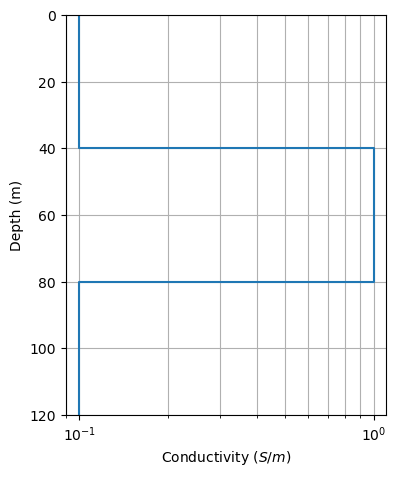

In [9]:
fig = plt.figure(figsize=(4, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax1 = plot_1d_layer_model(layer_thicknesses, layer_conductivities, scale="log", ax=ax1) # from simpeg
ax1.grid(which="both")
ax1.set_xlabel(r"Conductivity ($S/m$)")
plt.show()

**1. Conductivity model:** For forward simulation, the easiest approach is to define the model as the layer conductivities and set the layer thicknesses as a static property of the 1D simulation. In this case, the mapping from the model to the conductivities is defined using the [simpeg.maps.IdentityMap](xref:simpeg#simpeg.maps.IdentityMap) class.

**2. Parametric layered Earth model:** In this case, the model parameters are log-resistivities and layer thicknesses. We therefore need a mapping that extracts log-resistivities from the model and converts them into resistivities, and a mapping that extracts layer thicknesses from the model. For this, we require the [simpeg.maps.Wires](xref:simpeg#simpeg.maps.Wires) mapping and [simpeg.maps.ExpMap](xref:simpeg#simpeg.maps.ExpMap) mapping classes.

In [11]:
# Define model and mapping for a conductivity model.
conductivity_model = layer_conductivities.copy()
conductivity_map = maps.IdentityMap(nP=n_layers)

# Define model and mappings for the parametric model.
# Note the ordering in which you defined the model parameters and the
# order in which you defined the wire mappings matters!!!
parametric_model = np.r_[layer_thicknesses, np.log(1 / layer_conductivities)]
wire_map = maps.Wires(("thicknesses", n_layers - 1), ("log_resistivity", n_layers))
thicknesses_map = wire_map.thicknesses
log_resistivity_map = maps.ExpMap() * wire_map.log_resistivity

### Define forward simluation

In [13]:
simulation_conductivity = tdem.simulation_1d.Simulation1DLayered(
    survey=survey,
    sigmaMap=conductivity_map,
    thicknesses=layer_thicknesses,
)

In [14]:
simulation_parametric = tdem.simulation_1d.Simulation1DLayered(
    survey=survey,
    rhoMap=log_resistivity_map,
    thicknessesMap=thicknesses_map,
)

In [15]:
dpred_conductivity = simulation_conductivity.dpred(conductivity_model)
dpred_parametric = simulation_parametric.dpred(parametric_model)

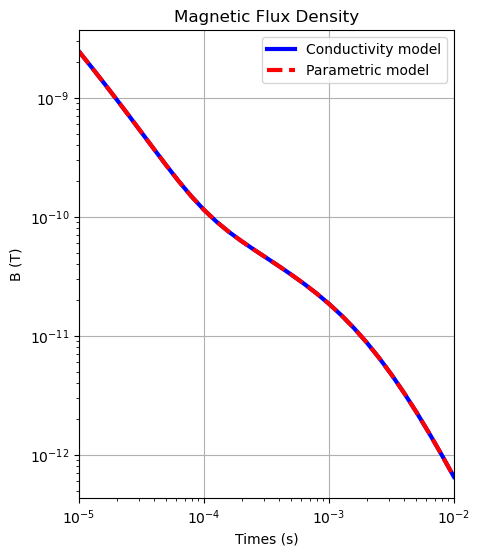

In [16]:
fig = plt.figure(figsize=(5, 6))
ax = fig.add_axes([0.2, 0.15, 0.75, 0.78])
ax.loglog(times, dpred_conductivity, "b-", lw=3)
ax.loglog(times, dpred_parametric, "r--", lw=3)
ax.set_xlim([times.min(), times.max()])
ax.grid()
ax.set_xlabel("Times (s)")
ax.set_ylabel("B (T)")
ax.set_title("Magnetic Flux Density")
ax.legend(["Conductivity model", "Parametric model"])
plt.show()